# ### Evaluating Returns and Backtesting

In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [26]:
symbols = ['ES=F', 'ZN=F', 'GC=F', 'DX=F']
start = '2000-01-01'
data = yf.download(symbols, start=start, auto_adjust=False)

[*********************100%***********************]  4 of 4 completed


In [27]:
data.head()

Price        Adj Close                      Close                       High  \
Ticker            DX=F ES=F GC=F ZN=F        DX=F ES=F GC=F ZN=F        DX=F   
Date                                                                           
2000-06-22  107.400002  NaN  NaN  NaN  107.400002  NaN  NaN  NaN  107.639999   
2000-06-23  107.720001  NaN  NaN  NaN  107.720001  NaN  NaN  NaN  107.879997   
2000-06-26  107.769997  NaN  NaN  NaN  107.769997  NaN  NaN  NaN  108.260002   
2000-06-27  106.980003  NaN  NaN  NaN  106.980003  NaN  NaN  NaN  107.849998   
2000-06-28  107.250000  NaN  NaN  NaN  107.250000  NaN  NaN  NaN  107.599998   

Price            ...  Low             Open                Volume            \
Ticker     ES=F  ... GC=F ZN=F        DX=F ES=F GC=F ZN=F   DX=F ES=F GC=F   
Date             ...                                                         
2000-06-22  NaN  ...  NaN  NaN  107.099998  NaN  NaN  NaN  666.0  NaN  NaN   
2000-06-23  NaN  ...  NaN  NaN  107.430000  NaN  NaN  NaN  258.0  NaN  NaN   
2000-06-26  NaN  ...  NaN  NaN  107.680000  NaN  NaN  NaN  266.0  NaN  NaN   
2000-06-27  NaN  ...  NaN  NaN  107.849998  NaN  NaN  NaN  669.0  NaN  NaN   
2000-06-28  NaN  ...  NaN  NaN  107.059998  NaN  NaN  NaN  258.0  NaN  NaN   

Price            
Ticker     ZN=F  
Date             
2000-06-22  NaN  
2000-06-23  NaN  
2000-06-26  NaN  
2000-06-27  NaN  
2000-06-28  NaN  

[5 rows x 24 columns]

## Resample data

In [28]:
data = data.resample('ME').last()
data.index = pd.to_datetime(data.index)

In [29]:
# Slice data of Multi Index DataFrames
prices = data.loc[:,pd.IndexSlice['Adj Close', :]]

In [30]:
prices.index = pd.to_datetime(prices.index)

In [31]:
# Remove multi-index of Dataframe

# prices.columns = prices.columns.droplevel(0)

In [32]:
prices = prices.ffill()

In [33]:
prices.dropna(inplace=True)

In [34]:
prices.isna().sum()

Price      Ticker
Adj Close  DX=F      0
           ES=F      0
           GC=F      0
           ZN=F      0
dtype: int64

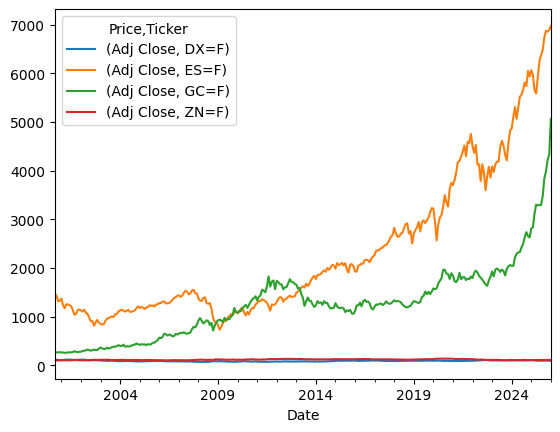

In [35]:
prices.plot()
plt.show()

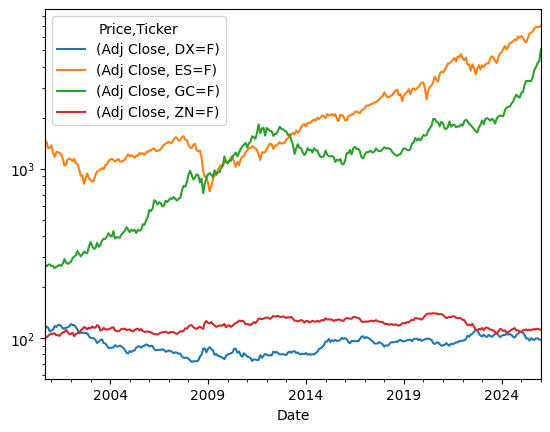

In [36]:
prices.plot()
plt.yscale("log")
plt.show()

## Calculate Returns

In [37]:
# Compute arithmetic returns
returns = prices['Adj Close'].pct_change()

In [38]:
returns.dropna(inplace=True)
returns.head(5)

Ticker,DX=F,ES=F,GC=F,ZN=F
Date,,,,
2000-10-31,0.032035,-0.009113,-0.031798,0.004832
2000-11-30,-0.013034,-0.083116,0.019630,0.019860
2000-12-31,-0.050565,0.004542,0.007034,0.021299
2001-01-31,0.011439,0.035041,-0.023529,0.005661
2001-02-28,0.013300,-0.095741,0.004518,0.008147


## Compute Risk-Parity weights

In [39]:
def compute_risk_parity(returns, window_size=36):
    #Compute volatility known at time t
    rolling_vol = returns.rolling(window_size).std()
    rolling_inverse_vol = 1 / rolling_vol
    
    risk_parity_weights = rolling_inverse_vol.div(rolling_inverse_vol.sum(axis=1),axis=0)
    
    risk_parity_weights = risk_parity_weights.shift(1)
    
    return risk_parity_weights

In [40]:
risk_parity_weights = compute_risk_parity(returns, 36)

In [41]:
risk_parity_weights.dropna(inplace=True)

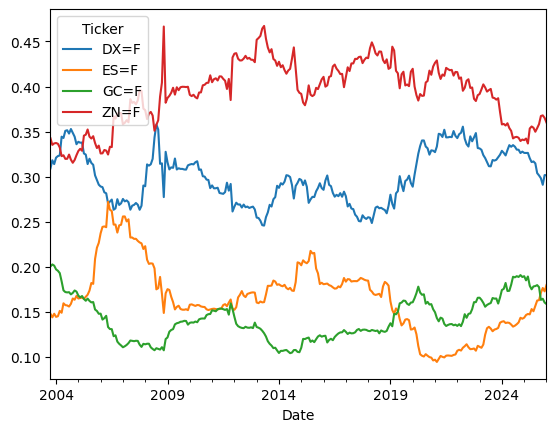

In [42]:
risk_parity_weights.plot()
plt.show()

## Calculate Weighted Returns

In [43]:
weighted_returns = returns * risk_parity_weights
risk_parity_portfolio_returns = weighted_returns.sum(axis=1)
print(risk_parity_portfolio_returns)

Date
2000-10-31    0.000000
2000-11-30    0.000000
2000-12-31    0.000000
2001-01-31    0.000000
2001-02-28    0.000000
                ...   
2025-09-30    0.024856
2025-10-31    0.016678
2025-11-30    0.011185
2025-12-31   -0.002390
2026-01-31    0.023568
Freq: ME, Length: 304, dtype: float64


## Evaluate Portfolio Performance

In [44]:
# Evaluate Portfolio performance
annual_mean_return = risk_parity_portfolio_returns.mean() * 12
annual_volatility = risk_parity_portfolio_returns.std() * np.sqrt(12)

skewness = risk_parity_portfolio_returns.skew()
kurtosis = risk_parity_portfolio_returns.kurtosis() + 3

# Compute drawdown
cumulative_returns = (1 + risk_parity_portfolio_returns).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (running_max - cumulative_returns) / running_max
max_drawdown = drawdown.max()

# Compute Sharpe Ratio
sharpe_ratio = annual_mean_return/annual_volatility

# Compute Sortino ratio
downside_std = cumulative_returns[cumulative_returns < 0].std() * np.sqrt(12)
sortino_ratio = annual_mean_return/downside_std

# Compute Calmar ratio
calmar_ratio = annual_mean_return/max_drawdown

# Display results
print(f'Mean Annual Returns: {annual_mean_return: .4f}')
print(f'Annual Volatility: {annual_volatility: .4f}')
print(f'Skewness: {skewness: .4f}')
print(f'Kurtosis: {kurtosis: .4f}')
print(f'Maximum Drawdown: {max_drawdown: .4f}')
print(f'Sharpe ratio: {sharpe_ratio: .4f}')
print(f'Sortino Ratio: {sortino_ratio: .4f}')
print(f'Calmar Ratio: {calmar_ratio: .4f}')

Mean Annual Returns:  0.0327
Annual Volatility:  0.0340
Skewness:  0.3225
Kurtosis:  4.4670
Maximum Drawdown:  0.0496
Sharpe ratio:  0.9632
Sortino Ratio:  nan
Calmar Ratio:  0.6594


## Plot Returns

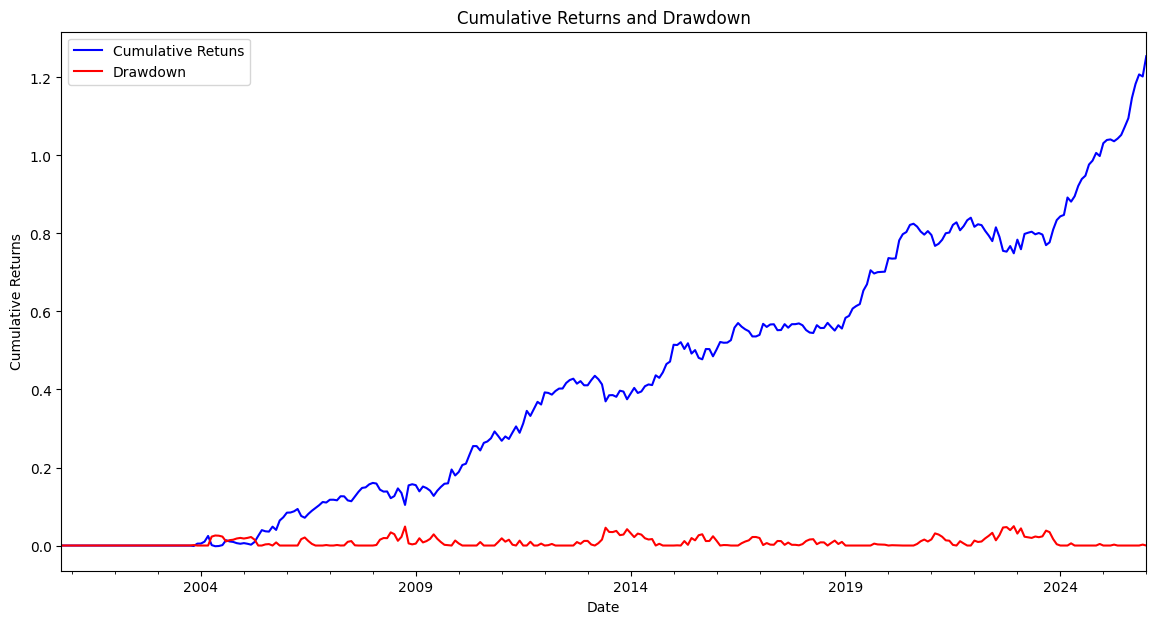

In [45]:
fig, ax = plt.subplots(figsize= (14, 7))
(cumulative_returns - 1).plot(ax=ax, label='Cumulative Retuns', color='blue')
drawdown.plot(ax=ax, label='Drawdown', color='red')
ax.set_title('Cumulative Returns and Drawdown')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')
ax.legend()
plt.show()